In [20]:
import os, glob, h5py
import numpy as np
from pynwb import NWBHDF5IO
from pynwb import NWBFile
from datetime import datetime
import matplotlib.pyplot as plt

from ecog.utils.HTK import read_HTKs
from ecog.utils.electrodes import load_bad_electrodes, load_electrode_labels
from ecog.utils.load_bad_times import load_bad_times
from ecog.tokenize.transcripts import parse
from scipy.io import loadmat

from pynwb.ecephys import ElectricalSeries

from spectrumregression.tokenize import (load_bad_electrodes,
                                         load_bad_times,
                                        extract_windows)
from spectrumregression.utils import zscore, compute_baseline, good_examples_and_channels
from process_nwb.resample import resample

from sklearn.linear_model import LogisticRegressionCV as LR

# NWB conversion

In [2]:
folder = '/storage/cv_perception'
subject_blocks = glob.glob(os.path.join(folder, 'EC2*'))

In [3]:
subject_blocks

['/storage/cv_perception/EC2_B106.nwb',
 '/storage/cv_perception/EC2_B44',
 '/storage/cv_perception/EC2_B44.nwb',
 '/storage/cv_perception/EC2_B4.nwb',
 '/storage/cv_perception/EC2_B83.nwb',
 '/storage/cv_perception/EC2_B88',
 '/storage/cv_perception/EC2_B46',
 '/storage/cv_perception/EC2_B46.nwb',
 '/storage/cv_perception/EC2_B83',
 '/storage/cv_perception/EC2_B88.nwb',
 '/storage/cv_perception/EC2_B4',
 '/storage/cv_perception/EC2_B106',
 '/storage/cv_perception/EC2_B72']

In [93]:
with NWBHDF5IO('/storage/ecog/nwb/EC2/EC2_B1.nwb', 'r') as f:
    io = f.read()
    electrodes = io.electrodes[:]
    eg = io.electrode_groups['L256Grid electrodes']
    device = io.devices['L256Grid']
    print(io)

root pynwb.file.NWBFile at 0x139757518290560
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    L256Grid <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    L256Grid electrodes <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2019, 6, 19, 11, 7, 43, 198581, tzinfo=tzoffset(None, -25200))]
  identifier: EC2_B1
  institution: University of California, San Francisco
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>,
    invalid_times <class 'pynwb.epoch.TimeIntervals'>,
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  invalid_times: invalid_times <class 'pynwb.epoch.TimeIntervals'>
  lab: Chang Lab
  processing: {
    preprocessing <class 'pynwb.base.ProcessingModule'>
  }
  session_description: EC2_B1
  session_id: EC2_B1
  session_start_time: 1900-01-01 08:0

In [101]:
for subject_block in subject_blocks:
    sb = os.path.split(subject_block)[1]
    nwb = NWBFile('CV perception {}'.format(sb),
                  sb,
                  datetime(2020, 2, 4))
    
    bad_electrodes = load_bad_electrodes(subject_block)
    new_device = nwb.create_device(device.name, device.description, device.manufacturer)
    new_eg = nwb.create_electrode_group(eg.name, eg.description, eg.location, new_device)
    nwb.add_electrode_column('bad', 'bad')
    for ec in electrodes.values:
        nwb.add_electrode(*ec[:6], new_eg, bad=ec[8])
    region = nwb.create_electrode_table_region(list(range(256)), 'grid')

    transcript = loadmat(os.path.join(folder, sb, '{}events.mat'.format(sb)))['evnt'][0]
    nwb.add_trial_column('speaker', 'speaker')
    nwb.add_trial_column('cv', 'cv')
    for item in transcript:
        nwb.add_trial(item[3][0][0], item[4][0][0], speaker=item[0][0].split('_')[0], cv=item[0][0].split('_')[1])

    bad_times = load_bad_times(subject_block)
    for st, en in bad_times:
        nwb.add_invalid_time_interval(start_time=st, stop_time=en)

    d = read_HTKs(os.path.join(folder, sb, 'RawHTK'))
    es = ElectricalSeries('ElectricalSeries', data=d['data'].T, electrodes=region,
                          rate=d['sampling_rate']/1e4)
    nwb.add_acquisition(es)
    with NWBHDF5IO(os.path.join(folder, '{}.nwb'.format(sb)), 'w') as f:
        f.write(nwb)

TypeError: NWBFile.add_trial: incorrect type for 'start_time' (got 'uint16', expected 'float')

# Create dataset

In [3]:
new_rate = 200.

In [4]:
folder = '/storage/cv_perception/preprocess/'
subject_blocks = glob.glob(os.path.join(folder, 'EC2*.nwb'))

In [5]:
subject_blocks

['/storage/cv_perception/preprocess/EC2_B106.nwb',
 '/storage/cv_perception/preprocess/EC2_B44.nwb',
 '/storage/cv_perception/preprocess/EC2_B4.nwb',
 '/storage/cv_perception/preprocess/EC2_B83.nwb',
 '/storage/cv_perception/preprocess/EC2_B46.nwb',
 '/storage/cv_perception/preprocess/EC2_B88.nwb']

In [27]:
data = []
blocks = []
speakers = []
cvs = []

for sb in sorted(subject_blocks, key=lambda x: int(x.split('_B')[1].split('.')[0])):
    f = NWBHDF5IO(sb, 'r')
    block = int(sb.split('_B')[1].split('.')[0])
    io = f.read()
    locations = io.ec_electrodes.to_dataframe()['location'].values
    ecs = locations == 'superiortemporal'
    
    X = io.processing['preprocessing']['wvlt_amp_CAR_ln_downsampled_ElectricalSeries'].data[:]
    X = X[:, ecs]
    rate = io.processing['preprocessing']['wvlt_amp_CAR_ln_downsampled_ElectricalSeries'].rate
    Xp = resample(X, new_rate, rate, axis=0)
    
    silence_time = [io.trials.to_dataframe()['stop_time'].max() + 3., X.shape[0] / rate]
    start_times = io.trials.to_dataframe()['start_time'].values
    bad_times=load_bad_times(io)
    bad_ecs = load_bad_electrodes(io)
    assert ~bad_ecs.max()

    speaker = io.trials.to_dataframe()['speaker'].values
    cv = io.trials.to_dataframe()['cv'].values
    
    Xp, means, stds, baseline = zscore(Xp, silence_time, new_rate, bad_times=bad_times)
    Xp = Xp.mean(axis=-1)
    D = extract_windows(Xp, new_rate, start_times, [-.2, .8], bad_times)
    
    data.append(D)
    blocks.append(np.ones(D.shape[0], dtype=int) * block)
    speakers.append(speaker)
    cvs.append(cv)
    f.close()

data = np.concatenate(data)
good_examples, good_channels = good_examples_and_channels(data[..., np.newaxis])
data = data[good_examples][..., good_channels]
blocks = np.concatenate(blocks)[good_examples]
speakers = np.concatenate(speakers)[good_examples]
cvs = np.concatenate(cvs)[good_examples]


with h5py.File('cv_perception.h5', 'w') as f:
    f.create_dataset('X', data=data.astype('float32'))
    f.create_dataset('blocks', data=blocks)
    f.create_dataset('speakers', data=speakers.astype(np.string_))
    f.create_dataset('cvs', data=cvs.astype(np.string_))

In [28]:
with h5py.File('cv_perception.h5', 'r') as f:
    X = f['X'][:]
    blocks = f['blocks'][:]
    speakers = f['speakers'][:]
    cvs = f['cvs'][:]

In [11]:
X.shape

(5184, 200, 51)

In [ ]:
goo

In [12]:
np.unique(cvs)

array([b'ba', b'bi', b'bu', b'da', b'di', b'du', b'ga', b'gi', b'gu',
       b'ka', b'ki', b'ku', b'la', b'li', b'lu', b'ma', b'mi', b'mu',
       b'na', b'ni', b'nu', b'pa', b'pi', b'pu', b'ra', b'ri', b'ru',
       b'sa', b'sha', b'shi', b'shu', b'si', b'su', b'ta', b'ti', b'tu',
       b'va', b'vi', b'vu', b'wa', b'wi', b'wu', b'ya', b'yi', b'yu',
       b'za', b'zi', b'zu'], dtype='|S3')

# Regression

In [73]:
cons = np.array([cv[:-1] for cv in cvs])
vowels = np.array([cv[-1:] for cv in cvs])
Xm = X - X.mean(axis=0, keepdims=True)

In [61]:
model = LR(max_iter=1000)
T = 70

In [63]:
model.fit(Xm[:, T], cvs)
print(model.score(Xm[:, T], cvs))

0.15965196276811008


In [77]:
rng = np.random.RandomState(0)
cvsp = rng.permutation(cvs)
consp = rng.permutation(cons)
vowelsp = rng.permutation(vowels)
model.fit(Xm[:, T], cvsp)
print(model.score(Xm[:, T], cvsp))

0.03439902873330635


In [95]:
#cv_accuracy = np.zeros((2, Xm.shape[1]))
c_accuracy = np.zeros((2, Xm.shape[1]))
v_accuracy = np.zeros((2, Xm.shape[1]))
#cv_accuracies = np.zeros((2, Xm.shape[1], np.unique(cvs).size))
c_accuracies = np.zeros((2, Xm.shape[1], np.unique(cons).size))
v_accuracies = np.zeros((2, Xm.shape[1], np.unique(vowels).size))

for ti in range(Xm.shape[1]):
    print(ti)
    Xi = Xm[:, ti]
    """
    model.fit(Xm[:, ti], cvs)
    cv_accuracy[0, ti] = model.score(Xm[:, ti], cvs)
    for ii, cv in enumerate(np.unique(cvs)):
        idxs = cvs == cv
        cv_accuracies[0, ti, ii] = model.score(Xm[idxs, ti], cvs[idxs])
    model.fit(Xm[:, ti], cvsp)
    cv_accuracy[1, ti] = model.score(Xm[:, ti], cvsp)
    for ii, cv in enumerate(np.unique(cvs)):
        idxs = cvsp == cv
        cv_accuracies[1, ti, ii] = model.score(Xm[idxs, ti], cvsp[idxs])
    """
    model.fit(Xm[:, ti], cons)
    c_accuracy[0, ti] = model.score(Xm[:, ti], cons)
    for ii, c in enumerate(np.unique(cons)):
        idxs = cons == c
        c_accuracies[0, ti, ii] = model.score(Xm[idxs, ti], cons[idxs])
    model.fit(Xm[:, ti], consp)
    c_accuracy[1, ti] = model.score(Xm[:, ti], consp)
    for ii, c in enumerate(np.unique(cons)):
        idxs = consp == c
        c_accuracies[1, ti, ii] = model.score(Xm[idxs, ti], consp[idxs])
    
    model.fit(Xm[:, ti], vowels)
    v_accuracy[0, ti] = model.score(Xm[:, ti], vowels)
    for ii, v in enumerate(np.unique(vowels)):
        idxs = vowels == v
        v_accuracies[0, ti, ii] = model.score(Xm[idxs, ti], vowels[idxs])
    model.fit(Xm[:, ti], vowelsp)
    v_accuracy[1, ti] = model.score(Xm[:, ti], vowelsp)
    for ii, v in enumerate(np.unique(vowels)):
        idxs = vowelsp == v
        v_accuracies[1, ti, ii] = model.score(Xm[idxs, ti], vowelsp[idxs])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


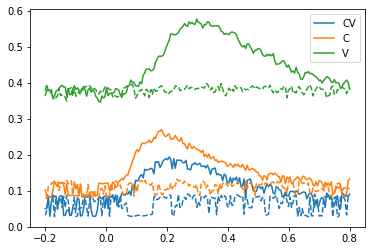

In [96]:
t = np.linspace(-.2, .8, 200)
plt.plot(t, cv_accuracy[0], c='C0', label='CV')
plt.plot(t, cv_accuracy[1], '--', c='C0')

plt.plot(t, c_accuracy[0], c='C1', label='C')
plt.plot(t, c_accuracy[1], '--', c='C1')

plt.plot(t, v_accuracy[0], c='C2', label='V')
plt.plot(t, v_accuracy[1], '--', c='C2')
plt.legend(loc='best')

Text(0, 0.5, 'Accuracy/chance')

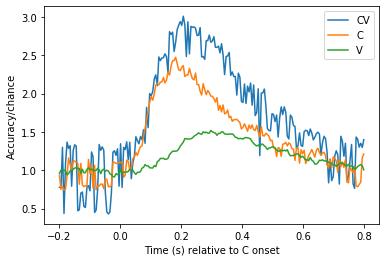

In [97]:
t = np.linspace(-.2, .8, 200)
plt.plot(t, cv_accuracy[0]/cv_accuracy[1].mean(), c='C0', label='CV')

plt.plot(t, c_accuracy[0]/c_accuracy[1].mean(), c='C1', label='C')

plt.plot(t, v_accuracy[0]/v_accuracy[1].mean(), c='C2', label='V')

plt.legend(loc='best')
plt.xlabel('Time (s) relative to C onset')
plt.ylabel('Accuracy/chance')

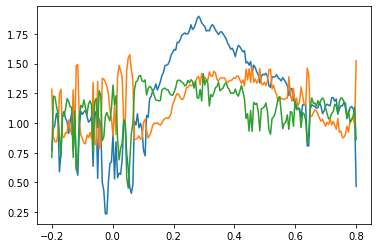

In [98]:
for ii in range(np.unique(vowels).size):
    plt.plot(t, v_accuracies[0, :, ii] / v_accuracies[1, :, ii].mean())

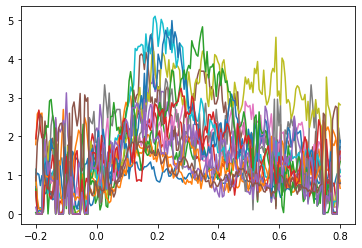

In [100]:
for ii in range(np.unique(cons).size):
    plt.plot(t, c_accuracies[0, :, ii] / c_accuracies[1, :, ii].mean())

In [25]:
good_examples.mean()

0.9533179012345679

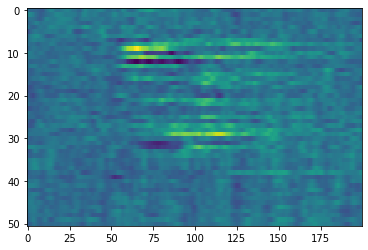

In [53]:
idxs = cvs == cvs[0]
plt.imshow(Xm[idxs].mean(axis=0).T, aspect='auto')

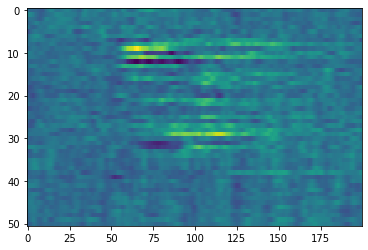

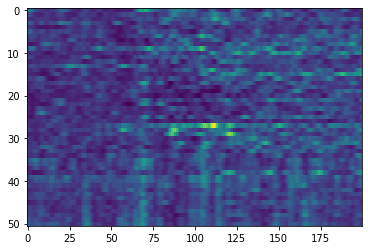

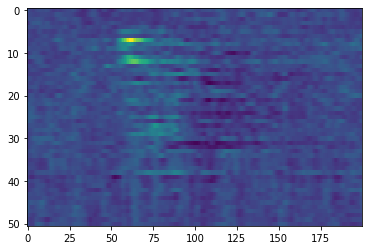

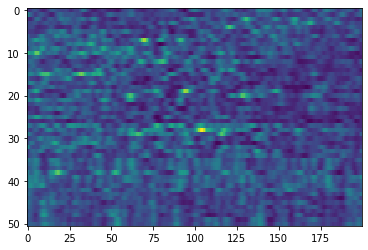

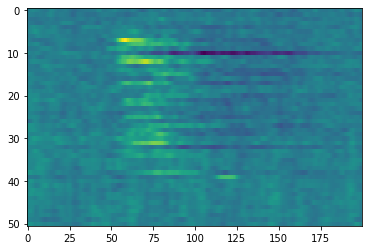

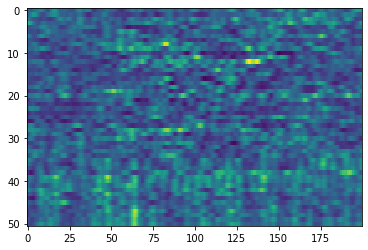

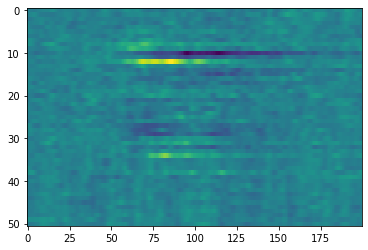

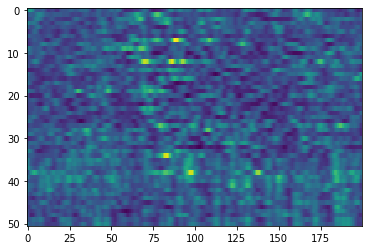

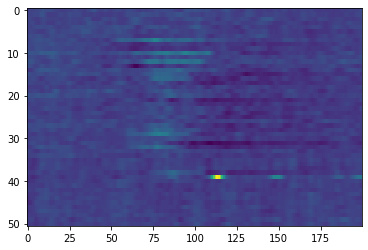

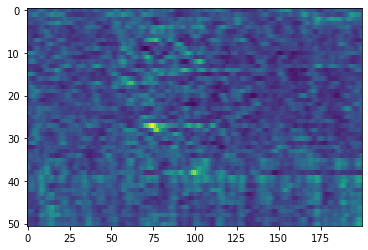

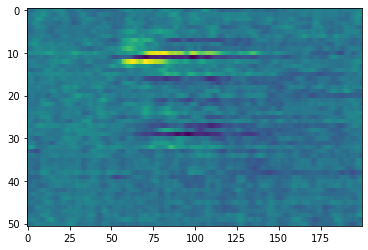

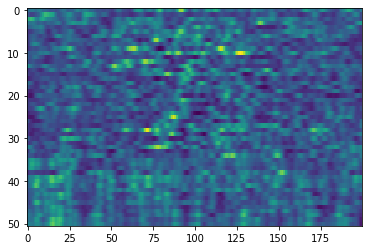

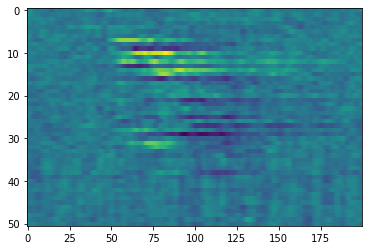

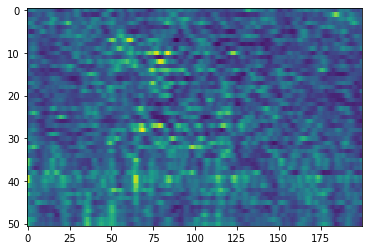

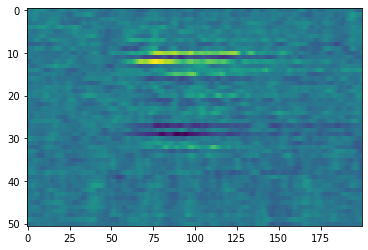

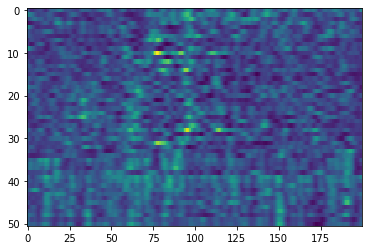

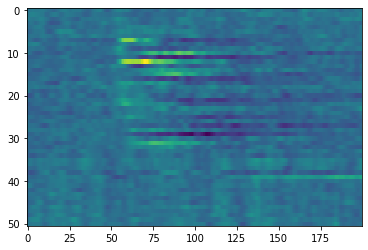

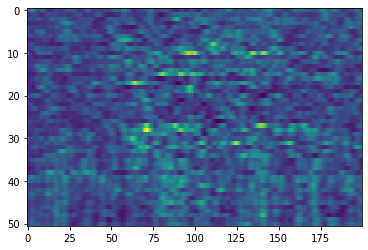

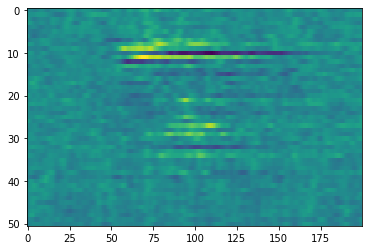

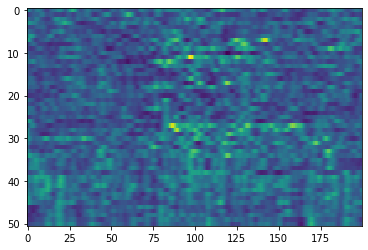

In [56]:
for ii in range(10):
    plt.figure()
    idxs = cvs == cvs[ii]
    plt.imshow(Xm[idxs].mean(axis=0).T, aspect='auto')
    plt.figure()
    plt.imshow(Xm[ii].T, aspect='auto')